In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle/dataset.csv


In [2]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

In [3]:
# --- 2. Load the Dataset ---
# Replace 'vehicles.csv' with your dataset path
df = pd.read_csv("/kaggle/input/vehicle/dataset.csv")

# Display first few rows
df.head()

,name,description,make,model,year,price,engine,cylinders,fuel,mileage,transmission,trim,body,doors,exterior_color,interior_color,drivetrain
0,2024 Jeep Wagoneer Series II,"\n \n Heated Leather Seats, Nav Sy...",Jeep,Wagoneer,2024,74600.0,24V GDI DOHC Twin Turbo,6.0,Gasoline,10.0,8-Speed Automatic,Series II,SUV,4.0,White,Global Black,Four-wheel Drive
1,2024 Jeep Grand Cherokee Laredo,Al West is committed to offering every custome...,Jeep,Grand Cherokee,2024,50170.0,OHV,6.0,Gasoline,1.0,8-Speed Automatic,Laredo,SUV,4.0,Metallic,Global Black,Four-wheel Drive
2,2024 GMC Yukon XL Denali,NaN,GMC,Yukon XL,2024,96410.0,"6.2L V-8 gasoline direct injection, variable v...",8.0,Gasoline,0.0,Automatic,Denali,SUV,4.0,Summit White,Teak/Light Shale,Four-wheel Drive
3,2023 Dodge Durango Pursuit,White Knuckle Clearcoat 2023 Dodge Durango Pur...,Dodge,Durango,2023,46835.0,16V MPFI OHV,8.0,Gasoline,32.0,8-Speed Automatic,Pursuit,SUV,4.0,White Knuckle Clearcoat,Black,All-wheel Drive
4,2024 RAM 3500 Laramie,\n \n 2024 Ram 3500 Laramie Billet...,RAM,3500,2024,81663.0,24V DDI OHV Turbo Diesel,6.0,Diesel,10.0,6-Speed Automatic,Laramie,Pickup Truck,4.0,Silver,Black,Four-wheel Drive


Shape: (1002, 17)

Missing values per column:
 name                0
description        56
make                0
model               0
year                0
price              23
engine              2
cylinders         105
fuel                7
mileage            34
transmission        2
trim                1
body                3
doors               7
exterior_color      5
interior_color     38
drivetrain          0
dtype: int64

Data types:
 name               object
description        object
make               object
model              object
year                int64
price             float64
engine             object
cylinders         float64
fuel               object
mileage           float64
transmission       object
trim               object
body               object
doors             float64
exterior_color     object
interior_color     object
drivetrain         object
dtype: object


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


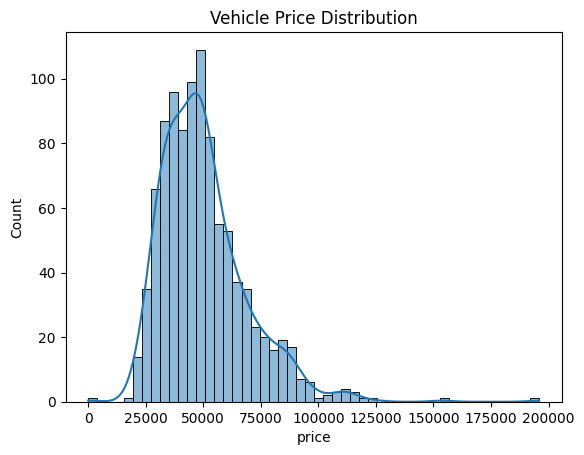

In [4]:
# --- 3. Basic Data Exploration ---

print("Shape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

# Quick look at price distribution
sns.histplot(df['price'], bins=50, kde=True)
plt.title("Vehicle Price Distribution")
plt.show()


In [5]:
# --- 4. Data Cleaning and Feature Selection ---

# Drop rows with missing price
df = df.dropna(subset=['price'])

# Fill missing numerical values with median
num_cols = ['year', 'mileage', 'cylinders', 'doors']
for col in num_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Fill missing categorical values with 'Unknown'
cat_cols = ['make', 'model', 'engine', 'fuel', 'transmission', 'body', 'drivetrain',
            'exterior_color', 'interior_color', 'trim']
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

# Optional: remove extreme outliers in price
df = df[df['price'] < df['price'].quantile(0.99)]


In [6]:
# --- 5. Feature Engineering ---

# Define final features and target
target = 'price'
features = ['year', 'mileage', 'cylinders', 'doors',
            'make', 'model', 'engine', 'fuel', 'transmission', 'body', 'drivetrain']

# Keep only columns that exist
features = [f for f in features if f in df.columns]

# Define categorical and numerical features
cat_features = ['make', 'model', 'engine', 'fuel', 'transmission', 'body', 'drivetrain']
num_features = ['year', 'mileage', 'cylinders', 'doors']


In [7]:
# --- 6. Train-Test Split ---

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 775
Testing samples: 194


In [8]:
# --- 7. CatBoost Model Training ---

# Identify categorical feature indices
cat_features = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype == 'object']

# Create CatBoost Pools
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# Define and train model
model = CatBoostRegressor(
    iterations=500,
    depth=8,
    learning_rate=0.1,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)


0:	learn: 16235.3780272	test: 14830.6613156	best: 14830.6613156 (0)	total: 69ms	remaining: 34.4s
100:	learn: 5452.9104815	test: 6605.1364042	best: 6605.1364042 (100)	total: 738ms	remaining: 2.91s
200:	learn: 4125.7871817	test: 6534.6013610	best: 6522.1689029 (157)	total: 1.4s	remaining: 2.09s
300:	learn: 3308.1106828	test: 6523.1486401	best: 6501.3775380 (272)	total: 2.05s	remaining: 1.36s
400:	learn: 2665.0981217	test: 6509.9545923	best: 6489.6267962 (338)	total: 2.74s	remaining: 676ms
499:	learn: 2258.2697420	test: 6510.6050844	best: 6489.6267962 (338)	total: 3.4s	remaining: 0us

bestTest = 6489.626796
bestIteration = 338

Shrink model to first 339 iterations.


📊 Model Performance:
MAE  = 4,629.42
RMSE = 6,489.63
R²   = 0.830


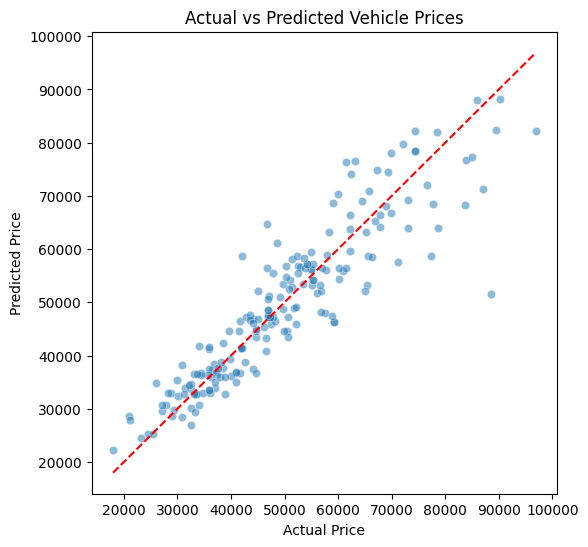

In [9]:
# --- 8. Evaluation ---

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 Model Performance:")
print(f"MAE  = {mae:,.2f}")
print(f"RMSE = {rmse:,.2f}")
print(f"R²   = {r2:.3f}")

# Plot predicted vs actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Vehicle Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


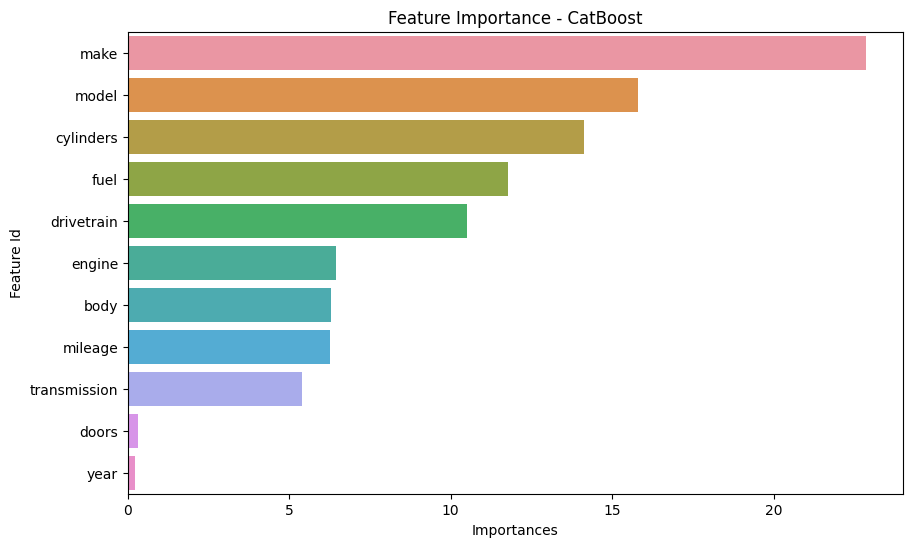

,Feature Id,Importances
0,make,22.854312
1,model,15.787103
2,cylinders,14.134419
3,fuel,11.788243
4,drivetrain,10.494409
5,engine,6.462662
6,body,6.307714
7,mileage,6.254558
8,transmission,5.385237
9,doors,0.304201


In [10]:
# --- 9. Feature Importance ---

importances = model.get_feature_importance(prettified=True)
plt.figure(figsize=(10,6))
sns.barplot(data=importances, x='Importances', y='Feature Id')
plt.title("Feature Importance - CatBoost")
plt.show()

importances


In [11]:
# --- 10. Save Model (optional) ---

model.save_model("catboost_vehicle_price_model.cbm")

print("✅ Model saved as 'catboost_vehicle_price_model.cbm'")


✅ Model saved as 'catboost_vehicle_price_model.cbm'
